## Natural Language Processing
This project includes features exploration, logistic regression, TFIDF, text similarity, RNN.


In [ ]:
# Imports 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import sklearn
import string
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

# Set the random seed for reproducibility
RAND_SEED = 27
random.seed(RAND_SEED)
np.random.seed(RAND_SEED)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras import Sequential
from keras import backend as K
import matplotlib as mpl
from tensorflow.keras import layers
import itertools
import keras
import spacy
import os
import nltk
nltk.download('punkt')


# Flag to let us know if we're currently running in Google Colab or locally
import sys
IN_COLAB = 'google.colab' in sys.modules

# Ensure we have compatible tensorflow and keras versions
!pip install keras==2.3.1
!pip install tensorflow==2.2.0

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<hr />

## Feature Exploration



In [ ]:
# This cell loads the SST-2 dataset [do not change!]
path_train = "https://drive.google.com/uc?id=1IsO72aOzjx-6eu2Z5VOaXZBShatNxBaj"
path_dev = "https://drive.google.com/uc?id=1tUiTEzR14wmYTdr0mYEKaDbj9-pN05-u"

# Load in the train and dev data
df_train = pd.read_csv(path_train, sep='\t')
df_dev = pd.read_csv(path_dev, sep='\t')
# We'll split df_dev into a validation and test set for the purposes of this assignment
df_dev, df_test = df_dev[:400], df_dev[400:]

# Load in the second set of train and dev data
df_train1 = pd.read_csv(path_train, sep='\t')
df_dev1 = pd.read_csv(path_dev, sep='\t')
# We'll split df_dev into a validation and test set for the purposes of this assignment
df_dev1, df_test1 = df_dev1[:400], df_dev1[400:]

# Quick look at the training data
pd.set_option('max_colwidth', 1000)
df_train[:10]

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates something rather beautiful about human nature,1
3,remains utterly satisfied to remain the same throughout,0
4,on the worst revenge-of-the-nerds clichés the filmmakers could dredge up,0
5,that 's far too tragic to merit such superficial treatment,0
6,"demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop .",1
7,of saucy,1
8,a depressed fifteen-year-old 's suicidal poetry,0
9,are more deeply thought through than in most ` right-thinking ' films,1


In [ ]:
def is_good(text: str) -> int:
  good_words = ['good', 'nice', 'love']
  for word in good_words:
    if re.search(' ' + word + ' ', text):
      return 1
  return 0

input_text = "that loves its characters and communicates something rather beautiful about human nature"
print(input_text)
print(is_good(input_text))  # should print 0

input_text = "I love NLP"
print(input_text)
print(is_good(input_text))  # should print 1

that loves its characters and communicates something rather beautiful about human nature
0
I love NLP
1


In [ ]:
def is_bad(text: str) -> int:
  bad_words = ['bad', 'ugly', 'boring']
  for word in bad_words:
    if re.search(' ' + word + ' ', text):
      return 1
  return 0
input_text = "that loves its characters and communicates something rather beautiful about human nature"
print(input_text)
print(is_bad(input_text))  # should print 0

input_text = "lockdowns can be boring but learning NLP totally makes up for it"
print(input_text)
print(is_bad(input_text))  # should print 1

that loves its characters and communicates something rather beautiful about human nature
0
lockdowns can be boring but learning NLP totally makes up for it
1


 
### Logistic Regression

In [ ]:
# Logistic sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Defining Logistic Regression Class
class LogisticReg():
    def __init__(self, rand_seed=RAND_SEED):
        self.rand_seed = rand_seed
        np.random.seed(self.rand_seed)  # set the random seed for reproducibility
        self.w1 = np.random.randn()
        self.w2 = np.random.randn()
        self.b = np.random.randn()
        
    def forward(self, x1: int, x2: int) -> int:
        weighted_sum = self.w1*x1 + self.w2*x2 + self.b
        activation = sigmoid(weighted_sum)
        return activation

# Defining function to undertake is_good and is_bad featurisation
def featurisation(text):
  functions = [is_good, is_bad]
  return np.array([x(text) for x in functions])

# Creating column to indicate featurisation for every row
df_train['features'] = df_train['sentence'].apply(featurisation)
df_dev['features'] = df_dev['sentence'].apply(featurisation)

# Training Logistic Regression Model for df_train
training_prob = []
logit_model = LogisticReg()
for x1, x2 in df_train['features']:
  prob = logit_model.forward(x1, x2)
  training_prob.append(prob)

# Training Logistic Regression Model for df_dev
dev_prob = []
for x1, x2 in df_dev['features']:
  dev_prob.append(prob)

# We can also get the predictions by applying our threshold
threshold = 0.5
training_predictions = [1 if p >= 0.5 else 0 for p in training_prob]
training_predictions[:10]
dev_predictions = [1 if p >= 0.5 else 0 for p in dev_prob]
dev_predictions

# Compute the accuracy score
def accuracy(y_true: list, y_pred: list) -> int:
    assert len(y_true) == len(y_pred), "y_true and y_pred must be the same length"
    num_correct = 0
    for y_t, y_p in zip(y_true, y_pred):
        if y_t == y_p:
            num_correct += 1
    return 100*num_correct / len(y_true)

training_model_acc = accuracy(df_train['label'], training_predictions)
print("The model's accuracy score is {:.2f}%".format(training_model_acc))

dev_model_acc = accuracy(df_dev['label'], dev_predictions)
print("The model's accuracy score is {:.2f}%".format(dev_model_acc))

The model's accuracy score is 55.78%
The model's accuracy score is 52.00%


In [ ]:
# Load the opinion lexicon
# Define where the data is located
DATA_DIR = "data/opinion-lexicon-en/"
path_pos_words = os.path.join(DATA_DIR, 'positive-words.txt')
path_neg_words = os.path.join(DATA_DIR, 'negative-words.txt')

if IN_COLAB:
    path_pos_words = "uc?id=15nUrNvPy0a9hpBStZ1rjZvU5I73glhVs"
    path_neg_words = "uc?id=1nlCloWzQ_SeI5jpptBgWX5GOjkmsJvMx"
    if not os.path.exists(path_pos_words):
      # If the files don't exist, download them from drive
      !wget https://drive.google.com/uc?id=15nUrNvPy0a9hpBStZ1rjZvU5I73glhVs
      !wget https://drive.google.com/uc?id=1nlCloWzQ_SeI5jpptBgWX5GOjkmsJvMx

# Load in the train and dev data
with open(path_pos_words, 'r', encoding='ISO-8859-1') as f:
    POS_WORDS = set([u''+word.strip()+'' for word in f.readlines()[30:]])
with open(path_neg_words, 'r', encoding='ISO-8859-1') as f:
    NEG_WORDS = set([u''+word.strip()+'' for word in f.readlines()[31:]]) 

print("Loaded {} positive and {} negative words.".format(len(POS_WORDS), len(NEG_WORDS)))
print("Example positive words: {}".format(list(POS_WORDS)[:6]))
print("Example negative words: {}".format(list(NEG_WORDS)[:6]))

# Apply manual feature engineering
# 1. Checking the number of words
def fe_num_words(tokens):
    return len(tokens)

# 2. Number of stopwords
def fe_num_stopwords(tokens):
    return len([token for token in tokens if token in STOP_WORDS])

# 3. Checking text length
def fe_text_len(tokens):
    return len(" ".join(tokens))

# 4. Checking positivity score  
def fe_positivity(tokens):
    score = 0
    for token in tokens:
        if token in POS_WORDS:
            score += 1
        if token in NEG_WORDS:
            score -= 1
    return score

# 5. Contains keyword good
def fe_contains_keyword_good(tokens):
    return int(any([token.lower() == "good" for token in tokens]))


# 6. Contains keyword bad
def fe_contains_keyword_bad(tokens):
    return int(any([token.lower() == "good" for token in tokens]))

# 7. Tokenising
def tokenise(text):
    return text.split()  # because punctuation is already separated by spaces

# Extract the features from the sentences
df_train['number_of_words'] = df_train['sentence'].apply(fe_num_words)
df_train['number_of_stopwords'] = df_train['sentence'].apply(fe_num_stopwords)
df_train['text_length'] = df_train['sentence'].apply(fe_text_len)
df_train['positivity_score'] = df_train['sentence'].apply(fe_positivity)
df_train['contains_keyword_good'] = df_train['sentence'].apply(fe_contains_keyword_good)
df_train['contains_keyword_bad'] = df_train['sentence'].apply(fe_contains_keyword_bad)
df_train['tokenised_sentence'] = df_train['sentence'].apply(tokenise)

df_dev['number_of_words'] = df_dev['sentence'].apply(fe_num_words)
df_dev['number_of_stopwords'] = df_dev['sentence'].apply(fe_num_stopwords)
df_dev['text_length'] = df_dev['sentence'].apply(fe_text_len)
df_dev['positivity_score'] = df_dev['sentence'].apply(fe_positivity)
df_dev['contains_keyword_good'] = df_dev['sentence'].apply(fe_contains_keyword_good)
df_dev['contains_keyword_bad'] = df_dev['sentence'].apply(fe_contains_keyword_bad)
df_dev['tokenised_sentence'] = df_dev['sentence'].apply(tokenise)

# Set model
logreg_model = LogisticRegression()

# Define X and y training sets
X_train_logreg = df_train.drop(['sentence','label', 'features','tokenised_sentence'], axis = 1)
y_train_logreg = df_train['label']

# Fit model on training set
logreg_model.fit(X_train_logreg, y_train_logreg)

y_train_prediction_logreg = logreg_model.predict(X_train_logreg)
accuracy_score_train_logreg = accuracy_score(y_train_logreg, y_train_prediction_logreg)
print('The accuracy score of the training set is {:.2f}%'.format(100*accuracy_score_train_logreg))

# Define X and y dev sets
X_dev_logreg = df_dev.drop(['sentence','label', 'features','tokenised_sentence'], axis = 1)
y_dev_logreg = df_dev['label']

# Fit model on dev set
logreg_model.fit(X_dev_logreg, y_dev_logreg)

y_dev_prediction_logreg = logreg_model.predict(X_dev_logreg)
accuracy_score_dev_logreg = accuracy_score(y_dev_logreg, y_dev_prediction_logreg)
print('The accuracy score of the dev set is {:.2f}%'.format(100*accuracy_score_dev_logreg))

Loaded 2006 positive and 4783 negative words.
Example positive words: ['saintliness', 'openly', 'pros', 'straightforward', 'phenomenally', 'fervidly']
Example negative words: ['sarcasm', 'sidetracked', 'dizzingly', 'clogs', 'malodorous', 'smelt']
The accuracy score of the training set is 56.58%
The accuracy score of the dev set is 55.25%


### TFIDF
Training a Logistic Regression model on the TFIDF representations of the input texts.

In [ ]:
# Define the vectorizer
vectorizer = TfidfVectorizer()

# Define the inputs (x) and labels (y)
x_train, y_train = df_train1['sentence'].values, df_train1['label'].values
x_dev, y_dev = df_dev1['sentence'].values, df_dev1['label'].values

# Vectorize the inputs (ie convert the text to a Bag-Of-Words)
# First we fit to the training set
vectorizer.fit(x_train)

# Then we convert train and dev to BOW
x_train = vectorizer.transform(x_train)
x_dev = vectorizer.transform(x_dev)

# Train the model
logreg_model.fit(x_train, y_train)
y_pred_train = logreg_model.predict(x_train)
y_pred_dev = logreg_model.predict(x_dev)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
accuracy_score_dev = accuracy_score(y_dev, y_pred_dev)

print('The accuracy score for the training set is {:.2f}%'.format(100*accuracy_score_train))
print('The accuracy score for the dev set is {:.2f}%'.format(100*accuracy_score_dev))

The accuracy score for the training set is 92.26%
The accuracy score for the dev set is 82.75%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Error Analysis

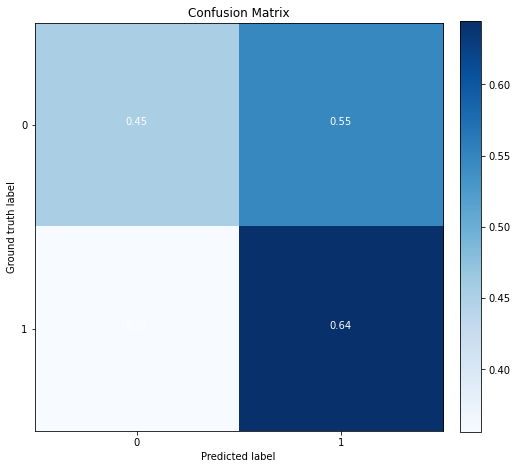

              precision    recall  f1-score   support

           0       0.54      0.45      0.49       192
           1       0.56      0.64      0.60       208

    accuracy                           0.55       400
   macro avg       0.55      0.55      0.55       400
weighted avg       0.55      0.55      0.55       400



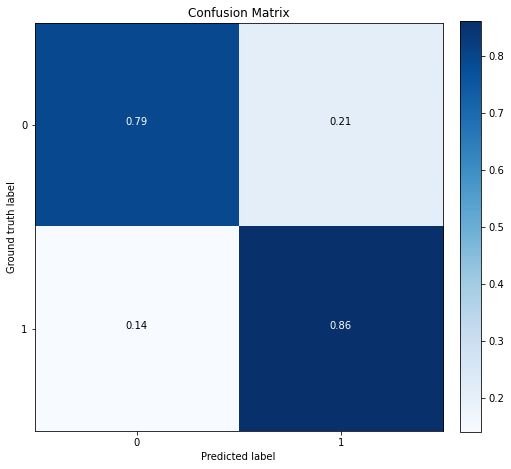

              precision    recall  f1-score   support

           0       0.84      0.79      0.82       192
           1       0.82      0.86      0.84       208

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(fraction=0.046, pad=0.04)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set(yticks=[-0.5, 1.5], 
           xticks=[0, 1], 
           yticklabels=classes, 
           xticklabels=classes)
    ax.yaxis.set_major_locator(mpl.ticker.IndexLocator(base=1, offset=0.5))
    if title:
        plt.title(title)
    plt.ylabel('Ground truth label')
    plt.xlabel('Predicted label')
    plt.show()

# Plotting the confusion matrix for my feature engineered Logistic Regression model
cm_logreg = confusion_matrix(y_dev_logreg, y_dev_prediction_logreg)
plot_confusion_matrix(cm_logreg, ("0", "1"), normalize=True)

# Summarising feature engineered Logistic Regression in Classification Report
logreg_report = classification_report(y_dev_logreg, y_dev_prediction_logreg)
print(logreg_report)

# Plotting the confusion matrix for TFIDF Logistic Regression model
cm_tfidf = confusion_matrix(y_dev, y_pred_dev)
plot_confusion_matrix(cm_tfidf, ("0", "1"), normalize=True)

# Summarising TFIDF Logistic Regression in Classification Report
tfidf_report = classification_report(y_dev, y_pred_dev)
print(tfidf_report)

The TFIDF logisitic regression clearly shows the better results, with accuracy scores between 82% and 84%. Both precision and recall are higher in all cases as well. 

If we take into consideration that the functions used for feature generation contain only few inputs for both positive and negative words, in our own logistic regression, its limitation in terms of accuracy is more understandable. The input used to train the model is incomplete and insufficient to result in high accuracy.

Meanwhile, TFIDF converts a sentence to a vector, thereby incorporating all information existant to learn from. It now seems logical, that the TFIDF regression's performance is stronger.

<hr />

## Text Similarity 

In [ ]:
# https://github.com/zalandoresearch/flair
try:
  import flair
  assert flair.__version__ == '0.8', f"flair version is {flair.__version__}"
except ModuleNotFoundError or AssertionError:
  !pip install flair==0.8.0
  !pip install allennlp==0.9.0
  import flair

from flair.data import Sentence
from flair.embeddings import WordEmbeddings, ELMoEmbeddings, TransformerWordEmbeddings, TransformerDocumentEmbeddings

In [ ]:
# Preparing the sentences [do not change!]
sentence_1 = "She went for a walk in the park by the river bank"
sentence_2 = "The woman went strolling on the grass next to the stream"

### Calculating Cosine Similarity

In [ ]:
def get_similarity(embedding_1:np.array, embedding_2:np.array) -> float:
  similarity = cosine_similarity(embedding_1.reshape(1, -1), embedding_2.reshape(1, -1))[0][0]
  return similarity

embedding_1 = np.array([1, 1, 1, 1, 0, 0])
embedding_2 = np.array([0, 1, 1, 0, 1, 0])
print(get_similarity(embedding_1, embedding_2))  # should print 0.57735...
print(get_similarity(embedding_2, embedding_1))  # should print 0.57735...

0.5773502691896258
0.5773502691896258


### Calculating the similarity between TFIDF representations

In [ ]:
# Defining the vectorizer
vectorizer = TfidfVectorizer()

# Vectorizing the inputs
embedding = vectorizer.fit_transform(np.array([sentence_1, sentence_2])).toarray()

print(embedding[0])
print(embedding[1])

similarity_tfidf = get_similarity(embedding[0], embedding[1])
print(similarity_tfidf)

[0.30814893 0.30814893 0.30814893 0.         0.30814893 0.
 0.         0.30814893 0.30814893 0.30814893 0.         0.
 0.438501   0.         0.30814893 0.2192505  0.        ]
[0.         0.         0.         0.28792702 0.         0.28792702
 0.28792702 0.         0.         0.         0.28792702 0.28792702
 0.61458734 0.28792702 0.         0.20486245 0.28792702]
0.3144133558902702


### Calculating the similarity between mean GloVe embeddings

In [ ]:
glove_embeddings = WordEmbeddings('glove')

# Creating two sentences with flair above
Sentence_1 = Sentence(sentence_1)
Sentence_2 = Sentence(sentence_2)

# Embedding words in sentence
glove_embeddings.embed(Sentence_1)
glove_embeddings.embed(Sentence_2)

embedding_1 = []
embedding_2 = []

for token in Sentence_1:
    #embedding_1.append(token)
    embedding_1.append(token.embedding.mean())
    #embedding_1.append(token.embedding.shape)
    #embedding_1.append(token.embedding)

for token in Sentence_2:
    #embedding_2.append(token)
    embedding_2.append(token.embedding.mean())
    #embedding_2.append(token.embedding.shape)
    #embedding_2.append(token.embedding)


embedding_1 = np.array(embedding_1)
embedding_2 = np.array(embedding_2 + [0])

print(embedding_1)
print(embedding_2)

similarity_glove = get_similarity(embedding_1, embedding_2)
print(similarity_glove)

[ 0.02233418 -0.0111127  -0.03639515  0.02605014  0.05882604 -0.00126887
 -0.02795817  0.06225276 -0.03632449 -0.02795817  0.00499167 -0.00347114]
[-0.02795817  0.07971903 -0.0111127   0.02577948 -0.0044474  -0.02795817
  0.08872788 -0.03352142 -0.0797292  -0.02795817  0.08585544  0.        ]
-0.05504035622074767


### Calculating the similarity between mean ELMo embeddings

In [ ]:
elmo_embedding = ELMoEmbeddings('small')

# Creating two sentences with flair above
Sentence_1 = Sentence(sentence_1)
Sentence_2 = Sentence(sentence_2)

# Embedding words in sentence
elmo_embedding.embed(Sentence_1)
elmo_embedding.embed(Sentence_2)

embedding_1 = []
embedding_2 = []

for token in Sentence_1:
    #embedding_1.append(token)
    embedding_1.append(token.embedding.mean())
    #embedding_1.append(token.embedding.shape)
    #embedding_1.append(token.embedding)

for token in Sentence_2:
    #embedding_2.append(token)
    embedding_2.append(token.embedding.mean())
    #embedding_2.append(token.embedding.shape)
    #embedding_2.append(token.embedding)


embedding_1 = np.array(embedding_1)
embedding_2 = np.array(embedding_2 + [0])

print(embedding_1)
print(embedding_2)

similarity_elmo = get_similarity(embedding_1, embedding_2)
print(similarity_elmo)

100%|██████████| 54402456/54402456 [00:04<00:00, 12869144.82B/s]


[ 0.02146322  0.02527875  0.0030737   0.05224846  0.03047941  0.02038251
  0.00964355  0.00141862  0.04017749 -0.00787266  0.00820768  0.01495385]
[ 0.02418317  0.06235116  0.02639305  0.02987337  0.00402601 -0.01100979
  0.02265424 -0.00720762  0.00530811  0.00043804  0.04050986  0.        ]
0.5610834585979325


### Calculating the similarity between BERT document embeddings

In [ ]:
bert_embeddings = TransformerWordEmbeddings('bert-base-uncased')

# Creating two sentences with flair above
Sentence_1 = Sentence(sentence_1)
Sentence_2 = Sentence(sentence_2)

# Embedding words in sentence
bert_embeddings.embed(Sentence_1)
bert_embeddings.embed(Sentence_2)

embedding_1 = []
embedding_2 = []

for token in Sentence_1:
    #embedding_1.append(token)
    embedding_1.append(token.embedding.mean())
    #embedding_1.append(token.embedding.shape)
    #embedding_1.append(token.embedding)

for token in Sentence_2:
    #embedding_2.append(token)
    embedding_2.append(token.embedding.mean())
    #embedding_2.append(token.embedding.shape)
    #embedding_2.append(token.embedding)


embedding_1 = np.array(embedding_1)
embedding_2 = np.array(embedding_2 + [0])

print(embedding_1)
print(embedding_2)

similarity_elmo = get_similarity(embedding_1, embedding_2)
print(similarity_elmo)

similarity_bert = get_similarity(embedding_1, embedding_2)
print(similarity_bert)


[-0.01773675 -0.02151286 -0.01976501 -0.01862758 -0.0247204  -0.01915758
 -0.01818666 -0.02330722 -0.02069369 -0.01821152 -0.02320205 -0.02259364]
[-0.01714825 -0.01962513 -0.02095484 -0.02643562 -0.01923317 -0.01809569
 -0.02509827 -0.02365171 -0.02024531 -0.01799708 -0.02367722  0.        ]
0.9356291511269101
0.9356291511269101


In [ ]:
# Comparing similarities using same representation but different sentences
sentence_A = "Kat's favorite fruit to eat is a date." 
sentence_B = "Joe took Alexandria out on a date." 
print(sentence_A)
print(sentence_B)


# 1. Using sklearn's TfidfVectorizer
vectorizer = TfidfVectorizer()
embedding = vectorizer.fit_transform(np.array([sentence_A, sentence_B])).toarray()

print('TFDIF similarity:')
similarity_tfidf = get_similarity(embedding[0], embedding[1])
print(similarity_tfidf)


# 2. Using GloVe Word Embedding
glove_embeddings = WordEmbeddings('glove')

# Create two sentences with flair above
Sentence_A = Sentence(sentence_A)
Sentence_B = Sentence(sentence_B)

# Embed words in sentence
glove_embeddings.embed(Sentence_A)
glove_embeddings.embed(Sentence_B)

embedding_A = []
embedding_B = []

for token in Sentence_1:
    embedding_A.append(token.embedding.mean())

for token in Sentence_2:
    embedding_B.append(token.embedding.mean())
   

embedding_A = np.array(embedding_A)
embedding_B = np.array(embedding_B + [0])

print('\nGloVe similarity:')
similarity_glove = get_similarity(embedding_A, embedding_B)
print(similarity_glove)

# 3. Using ELMo Embeddings
elmo_embedding = ELMoEmbeddings('small')

# Embed words in sentence
elmo_embedding.embed(Sentence_A)
elmo_embedding.embed(Sentence_B)

embedding_C = []
embedding_D = []

for token in Sentence_1:
    embedding_C.append(token.embedding.mean())

for token in Sentence_2:
    embedding_D.append(token.embedding.mean())

embedding_C = np.array(embedding_C)
embedding_D = np.array(embedding_D + [0])

print('\nELMo similarity:')
similarity_elmo = get_similarity(embedding_C, embedding_D)
print(similarity_elmo)

# 4. Using BERT Embeddings
bert_embeddings = TransformerWordEmbeddings('bert-base-uncased')

bert_embeddings.embed(Sentence_A)
bert_embeddings.embed(Sentence_B)

embedding_E = []
embedding_F = []
for token in Sentence_A:
    embedding_E.append(token.embedding.mean())

for token in Sentence_B:
    embedding_F.append(token.embedding.mean())

embedding_E = np.array(embedding_E)
embedding_F = np.array(embedding_F + [0, 0])

print('\nBERT similarity:')
similarity_bert = get_similarity(embedding_E, embedding_F)
print(similarity_bert)

Kat's favorite fruit to eat is a date.
Joe took Alexandria out on a date.
TFDIF similarity:
0.0845798608014702

GloVe similarity:
0.9356291511269101

ELMo similarity:
0.9356291511269101

BERT similarity:
0.2117928470326491


We see ELMo and GloVe show the highest similarity between the sentences. While ELMo works on a character base, GloVe works on a word base. GloVe word embeddings are context insensitive, however, ELMo and BERT analyse context sensitive representations, thereby understanding that data has a different meaning. Thus, one would have expected ELMo to show a lower similarity than GloVe, however this could be counteracted by similar characters in both sentences(e.g. identical for the word 'date').

If you had to build a text similarity system, what would you propose using?
To analyse text similarity, rather than mere sentence similarity, I would propose going for ELMo or BERT, as they into consideration the context of the corpus. However, in general it makes sense to compare similarity using different methods, e.g. assessing similarity on a character- and on a word-basis.

<hr />

In [ ]:
# This cell loads the SST-2 dataset [do not change!]
path_train = "https://drive.google.com/uc?id=1IsO72aOzjx-6eu2Z5VOaXZBShatNxBaj"
path_dev = "https://drive.google.com/uc?id=1tUiTEzR14wmYTdr0mYEKaDbj9-pN05-u"

# Load in the train and dev data
df_train = pd.read_csv(path_train, sep='\t')
df_dev = pd.read_csv(path_dev, sep='\t')
# We'll split df_dev into a validation and test set for the purposes of this assignment
df_dev, df_test = df_dev[:400], df_dev[400:]

# Quick look at the training data
pd.set_option('max_colwidth', 1000)
df_train[:10]


,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates something rather beautiful about human nature,1
3,remains utterly satisfied to remain the same throughout,0
4,on the worst revenge-of-the-nerds clichés the filmmakers could dredge up,0
5,that 's far too tragic to merit such superficial treatment,0
6,"demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop .",1
7,of saucy,1
8,a depressed fifteen-year-old 's suicidal poetry,0
9,are more deeply thought through than in most ` right-thinking ' films,1


In [ ]:
#################### 1. Optimising model for best performance on validation set ####################
# Loading the GloVe embeddings
glove_embedding = WordEmbeddings('glove')
embedding_size = glove_embedding.embedding_length

# Building Vocab
training_sentences = df_train['sentence'].values
PAD_token = '[PAD]'
OOV_token = '[OOV]'
vocab = {
    PAD_token: 0,
    OOV_token: 1
}

# Looping through all the training sentences
for sentence in training_sentences:
    tokens = sentence.split()  # word tokenise
    for word in tokens:
        # If we haven't already added the word to the vocab and we have an embedding available for that word
        # We could alternatively add all the words, and learn the embeddings for the words which don't have a pre-trained embedding
        if word not in vocab and word in glove_embedding.precomputed_word_embeddings.vocab:
            vocab[word] = len(vocab)  # add the word to the vocab, using the next available index
            
vocab_size = len(vocab)  # store the vocab size
print('There are {} tokens in the vocab'.format(vocab_size))
# print(list(vocab.items())[:20])  # show the first items in the vocab

# Creating Embedding Matrix
# Initialising the embedding matrix with zeros
embedding_matrix = np.zeros(shape=(vocab_size, embedding_size))

# Now, for every word in the vocab, we will update the corresponding row in the embedding matrix with the
# pre-loaded GloVe vector
for word, word_index in vocab.items():
    if word in glove_embedding.precomputed_word_embeddings.vocab:  # if the word is in the pre-trained vocab
        word_embedding = glove_embedding.precomputed_word_embeddings.word_vec(word)
        # Save in the word_embedding matrix
        embedding_matrix[word_index, :] = word_embedding

# Show the word embeddings for the word "loves" at index 17
num_dimensions_to_show = 20
#print(glove_embedding.precomputed_word_embeddings.word_vec("loves")[:num_dimensions_to_show])
#print(embedding_matrix[17, :num_dimensions_to_show])

# Use the mean of the embeddings of all the words in the vocab to replace zeros
mean_embedding = np.mean(embedding_matrix, axis=0)  # calculate the mean across axis 0 (i.e. across the rows)
embedding_matrix[vocab[OOV_token], :] = mean_embedding
#print(embedding_matrix[vocab[OOV_token], :])

#  Convert all the Data from Words to Indices
def convert_words_to_indices(sentence: str) -> list:
    tokens = sentence.split()
    return [vocab[token] if token in vocab else vocab[OOV_token] for token in tokens]

# Convert all our training, validation and test sentences to indices
df_train['sentence_indices'] = df_train['sentence'].apply(convert_words_to_indices)
df_dev['sentence_indices'] = df_dev['sentence'].apply(convert_words_to_indices)
df_test['sentence_indices'] = df_test['sentence'].apply(convert_words_to_indices)

# Padding the data
# Find how long the longest sentence is
longest_sequence = max(df_train['sentence_indices'].apply(lambda x: len(x)))
print('The longest training sentence has {} tokens.'.format(longest_sequence))

# Pad tokens with 0s to the max sequence length (52) using `pre` padding i.e. put the 0s in front
def pad_sequence(tokens: list, maxlen: int = longest_sequence) -> list:
    pre = [0]*(maxlen - len(tokens))  # make a list of 0s the size that we need to prepend
    return pre + tokens

# Pad the training, validation and test data
df_train['sentence_indices'] = df_train['sentence_indices'].apply(pad_sequence)
df_dev['sentence_indices'] = df_dev['sentence_indices'].apply(pad_sequence)
df_test['sentence_indices'] = df_test['sentence_indices'].apply(pad_sequence)

df_dev[['sentence', 'sentence_indices', 'label']].head()


2021-03-24 14:29:09,504 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmpch8zs_0k


100%|██████████| 160000128/160000128 [00:17<00:00, 9347827.68B/s]

2021-03-24 14:29:27,453 copying /tmp/tmpch8zs_0k to cache at /root/.flair/embeddings/glove.gensim.vectors.npy


2021-03-24 14:29:27,712 removing temp file /tmp/tmpch8zs_0k
2021-03-24 14:29:29,191 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim not found in cache, downloading to /tmp/tmpzdw3z53_


100%|██████████| 21494764/21494764 [00:04<00:00, 5364977.70B/s]

2021-03-24 14:29:34,023 copying /tmp/tmpzdw3z53_ to cache at /root/.flair/embeddings/glove.gensim
2021-03-24 14:29:34,060 removing temp file /tmp/tmpzdw3z53_


There are 13771 tokens in the vocab
The longest training sentence has 52 tokens.


,sentence,sentence_indices,label
0,it 's a charming and often affecting journey .,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 141, 42, 62, 610, 20, 202, 1294, 2514, 70]",1
1,unflinchingly bleak and desperate,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2099, 20, 2681]",0
2,allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker .,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2302, 298, 31, 7053, 16, 11018, 128, 1, 31, 1, 62, 2358, 513, 55, 62, 1807, 502, 3007, 1350, 70]",1
3,"the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales .","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 835, 12, 5159, 12, 843, 12, 1443, 20, 5261, 76, 130, 4831, 297, 6, 2410, 42, 1, 3998, 70]",1
4,"it 's slow -- very , very slow .","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 141, 42, 1583, 225, 186, 12, 186, 1583, 70]",0


In [ ]:
# Ensuring we have compatible tensorflow and keras versions
!pip install keras==2.3.1
!pip install tensorflow==2.2.0

     |████████████████████████████████| 133kB 4.2MB/s 
ERROR: konoha 4.6.4 has requirement requests<3.0.0,>=2.25.1, but you'll have requests 2.23.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.26.4
    Uninstalling urllib3-1.26.4:
      Successfully uninstalled urllib3-1.26.4


In [ ]:
import keras
from keras import layers
from keras import backend as K

# Developing 5  multi-layer bidirectional LSTM-based RNN with dropout!
rnn_model = keras.Sequential()  # the keras Sequential class groups a linear stack of layers into a tf.keras.Model

# Add an Embedding layer expecting input vocab, and output dimenstion the size of our embeddings
# mask_zero = True tells the Embedding layer that we use index 0 for padded tokens
rnn_model.add(layers.Embedding(input_shape=(longest_sequence,), input_dim=vocab_size, output_dim=embedding_size, input_length=longest_sequence,
                           weights=[embedding_matrix], mask_zero=True, trainable=False))

# Create an LSTM layer
rnn_model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=True)))
rnn_model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=True)))  # and another layer
rnn_model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2)))  # layer with recurrent dropout
rnn_model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))  # and another layer
rnn_model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=False)))  # and another layer

# Add another Dense layer (with relu activation) and apply dropout
rnn_model.add(keras.layers.Dense(32, activation='relu'))
rnn_model.add(keras.layers.Dropout(rate=0.4))  # we will drop 40% of the input units at random during training

# Add a Dense layer with a single unit and sigmoid activation.
rnn_model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Show the model summary (notice that the dropout layer has no parameters)
rnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 52, 100)           1377100   
_________________________________________________________________
bidirectional (Bidirectional (None, 52, 512)           731136    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 52, 512)           1574912   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 52, 256)           656384    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 52, 256)           394240    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 32)               

In [ ]:
# Convert the data from dataframes to numpy arrays
X_train, y_train = np.vstack(df_train['sentence_indices'].values), df_train['label'].values
X_dev, y_dev = np.vstack(df_dev['sentence_indices'].values), df_dev['label'].values
X_test, y_test = np.vstack(df_test['sentence_indices'].values), df_test['label'].values

# Train the model
NUM_EPOCHS = 3
BATCH_SIZE = 1000

history = rnn_model.fit(X_train,  y_train,
                        batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                        validation_data=(X_dev, y_dev))

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
68/68 [==============================] - ETA: 0s - loss: 0.6092 - accuracy: 0.6615 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f3d4d833e60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the 

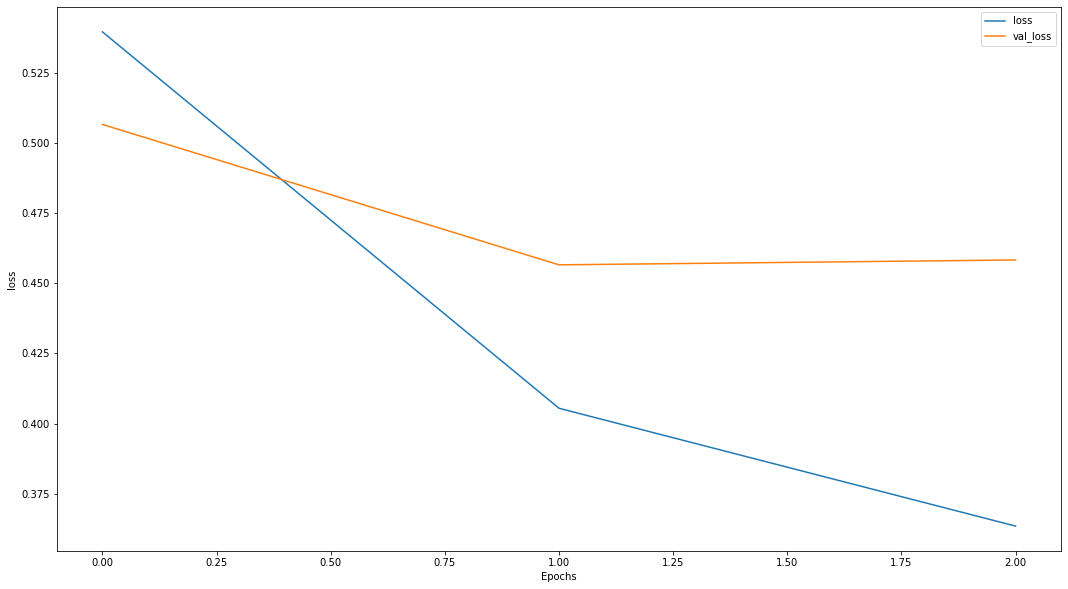

In [ ]:
#################### 2. Show plot of your model training and validation loss during training ####################
plt.rcParams['figure.figsize'] = (18, 10)  # set default figure size

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()
    
plot_graphs(history, 'loss')

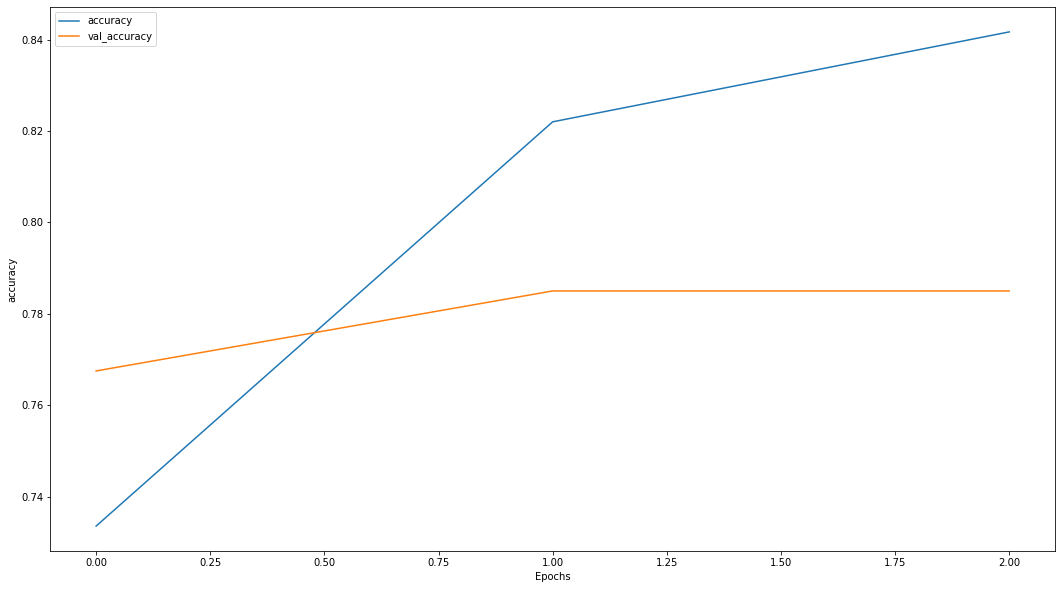

In [ ]:
#################### 3. Show a plot of your model training and validation accuracy during training ####################
plot_graphs(history, 'accuracy')

In [ ]:
#################### 4. Explain where you might want to stop the model training and why ####################
# Train the model (add early stopping)
NUM_EPOCHS = 7
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

history_earlystopping = rnn_model.fit(X_train,  y_train, 
                                      batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                                      validation_data=(X_dev, y_dev),callbacks=[early_stopping])

Epoch 1/7
68/68 [==============================] - 1816s 27s/step - loss: 0.3254 - accuracy: 0.8615 - val_loss: 0.4669 - val_accuracy: 0.8000
Epoch 2/7
68/68 [==============================] - 1825s 27s/step - loss: 0.2941 - accuracy: 0.8777 - val_loss: 0.4549 - val_accuracy: 0.8150
Epoch 3/7
68/68 [==============================] - 1836s 27s/step - loss: 0.2596 - accuracy: 0.8948 - val_loss: 0.5752 - val_accuracy: 0.8050
Epoch 4/7
68/68 [==============================] - 1824s 27s/step - loss: 0.2360 - accuracy: 0.9064 - val_loss: 0.5118 - val_accuracy: 0.8075
Epoch 5/7
68/68 [==============================] - 1841s 27s/step - loss: 0.2130 - accuracy: 0.9166 - val_loss: 0.4940 - val_accuracy: 0.8325
Epoch 6/7
68/68 [==============================] - 1836s 27s/step - loss: 0.1917 - accuracy: 0.9262 - val_loss: 0.6513 - val_accuracy: 0.8050
Epoch 7/7
68/68 [==============================] - 1846s 27s/step - loss: 0.1708 - accuracy: 0.9349 - val_loss: 0.5898 - val_accuracy: 0.8050


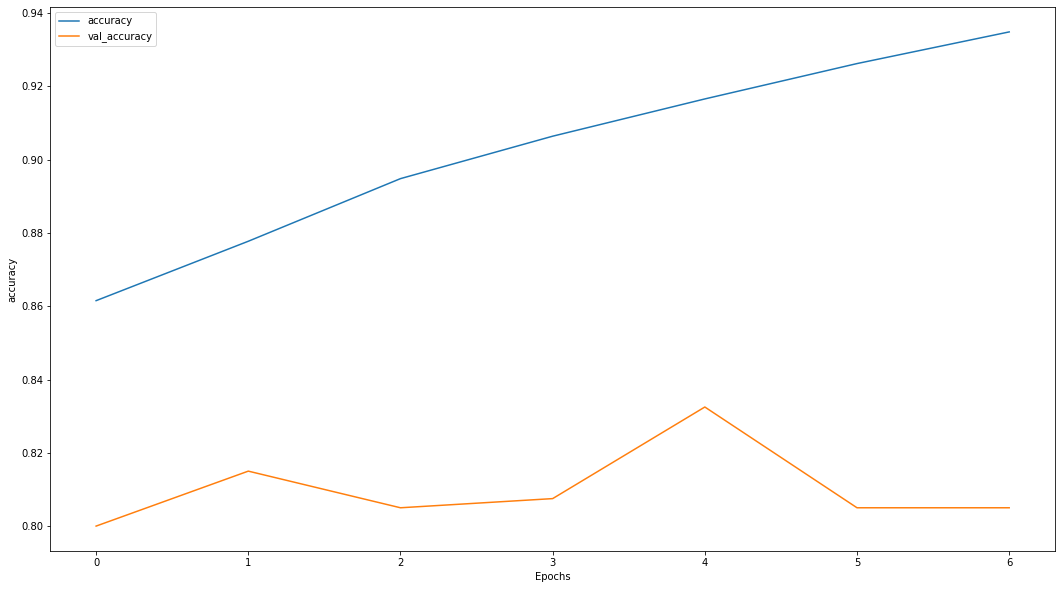

In [ ]:
#################### 5. Provide your model's best accuracy on the test set ####################
# Plot the graph of model accuracy
plot_graphs(history_earlystopping, 'accuracy')

In [ ]:
#################### 6. Perform an error analysis and compare to the models investigated in question 2 ####################
# Get the model predictions

def predict_sentiment(X, threshold=0.5):
    probabilities = rnn_model.predict(X)
    predictions = [1 if prob >= threshold else 0 for prob in probabilities]
    return predictions

# Show predictions on the dev set
df_dev_predict = df_dev.copy()
df_dev_predict['prediction'] = predict_sentiment(X_dev)
df_dev_predict[['sentence', 'label', 'prediction']][:20]

model_val_acc = 100 * accuracy_score(df_dev_predict['label'].values, df_dev_predict['prediction'].values)
print("The model's validation accuracy score is {:.2f}%".format(model_val_acc))

# Plot the confusion matrix for TFIDF Logistic Regression model
cm_tfidf = confusion_matrix(y_dev, y_pred_dev)
plot_confusion_matrix(cm_tfidf, ("0", "1"), normalize=True)

# Summarise TFIDF Logistic Regression in Classification Report
tfidf_report = classification_report(y_dev, y_pred_dev)
print(tfidf_report)

The model's validation accuracy score is 80.50%


In [ ]:
# Validity checks
for fn in [
    word_tokenize, 
    remove_stopwords, 
    is_good,
    is_bad,
    get_similarity
    ]:
  assert callable(fn)

for answer in [similarity_tfidf, similarity_glove, similarity_elmo, similarity_bert]:
  assert isinstance(answer, (np.floating, float)), f"{answer} is of type {type(answer)}"

for answer in [Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q9, Q10]:
  assert isinstance(answer, str), f"{answer} is of type {type(answer)}"

print("Validity checks passed!")

Validity checks passed!


<hr />